In [100]:
import numpy as np
import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, ConstraintList, Objective, SolverFactory, value, RangeSet

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint

# -------------- helper libraries -------------- #
import sys
import os
import time
import pickle
import matplotlib.pyplot as plt
import pandas as pd

collocation2_path = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data
from optimization_pyomo import ODEOptimizationModel as ODEOptimizationModel
from pickle_func import pickle_data, unpickle_data

# -------------- regular neural nets --------------
from neural_net import create_train_state, train, neural_ode

In [101]:
import importlib
import optimization_pyomo
import data_generation

importlib.reload(optimization_pyomo)
ODEOptimizationModel = optimization_pyomo.ODEOptimizationModel

importlib.reload(data_generation)
generate_ode_data = data_generation.generate_ode_data

### harmonic oscillator

In [3]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 2}
start_time, end_time = 0, 10
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights = compute_weights(t)
D = np.array(lagrange_derivative(t, weights))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test, y_test, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

### van der pol

In [106]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type, params = "van_der_pol", {"mu": 1, "omega": 1}
start_time, end_time = 0, 10
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_vdp, y_vdp, y_noisy_vdp, true_derivatives_vdp = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_vdp = np.array(jnp.squeeze(y_noisy_vdp))
t = np.array(jnp.squeeze(t))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights_vdp = compute_weights(t)
D_vdp = np.array(lagrange_derivative(t, weights_vdp))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_vdp, y_test_vdp, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative_vdp, estimated_solution_vdp = collocate_data(y_noisy_vdp, t, 'EpanechnikovKernel', bandwidth=0.5)

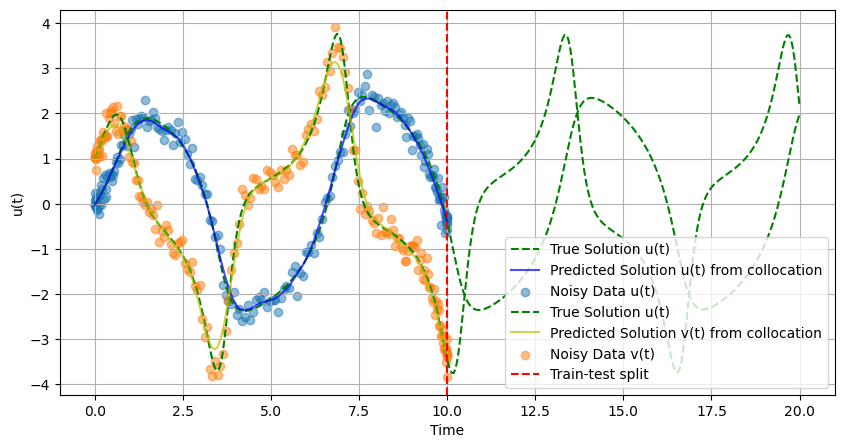

In [114]:
#---------------------------CHECK THE DATA--------------------------#
plt.figure(figsize=(10, 5))
plt.plot(t_test_vdp, y_test_vdp.T[0], 'g--', label='True Solution u(t)')
plt.plot(t, estimated_solution_vdp[0], 'b', alpha = 0.7, label='Predicted Solution u(t) from collocation')
plt.scatter(t, y_noisy_vdp.T[0], label='Noisy Data u(t)', alpha = 0.5)

#plt.plot(t, v_model, 'r', alpha = 0.7, label='Predicted Solution v(t) from model.v')
plt.plot(t_test_vdp, y_test_vdp.T[1], 'g--', label='True Solution u(t)')
plt.plot(t, estimated_solution_vdp[1], 'y', alpha = 0.7, label='Predicted Solution v(t) from collocation')
plt.scatter(t, y_noisy_vdp.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=10, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

## Hyper parameter optimization

### Single pass through

### `tol`

__init__(<br>
    self, y_observed, t, first_derivative_matrix, layer_sizes, <br>
    penalty_lambda=100, act_func="tanh", w_init_method="random", y_init = None, <br>
    `max_iter`=None, `max_cpu` = None, `tol` = None, `acceptable_tol` = None, `acceptable_iter` = None, <br>
    verbose=False, print_level = 4):

In [55]:
layer_widths = [2, 20, 2]
results_tol = {}

tol_li = np.logspace(-4.0, -7.0, num=10)  

for tol in tol_li:
    #---------------------------------MODEL---------------------------------#
    ode_model = ODEOptimizationModel(y_noisy, t, D, layer_widths, y_init = estimated_solution, tol = tol, verbose= True, print_level= 4)
    ode_model.build_model()
    result = ode_model.solve_model()
    
    #------------------------------ ODEINT PREP ----------------------------#
    def system_dynamics(y, t):
        u, v = y
        du_dt, dv_dt = ode_model.predict(u, v)
        return jnp.array([du_dt, dv_dt])
    
    initial_conditions = jnp.array([0.0, 1.0]) 
    #---------------------------MEAN ABSOLUTE ERROR--------------------------#

    y_pred_train = odeint(system_dynamics, initial_conditions, t)    
    mae_train = jnp.mean(jnp.abs(y_pred_train - y))
    
    y_pred_test = odeint(system_dynamics, initial_conditions, t_test)   
    mae_test = jnp.mean(jnp.abs(y_pred_test[200:] - y_test[200:]))
    
    #------------------------------SAVING RESULTS----------------------------#

    results_tol[tol] = {
        "tol":tol, "y_pred_train": y_pred_train, "y_pred_test" : y_pred_test, "t" : t,
        "time_elapsed": result['solver_time'], "mae_test" : mae_test, "mae":mae_train,
        "termination_condition": result['termination_condition'], "message": result['message']
        }

Ipopt 3.14.16: print_level=4
tol=0.0001


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total number of variables............................:      502
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      398
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      

In [60]:
df_results = pd.DataFrame(results_tol).T

df_results['tol_scientific'] = df_results['tol'].apply(lambda x: f"{x:.2e}")
df_results = df_results.sort_values(by = 'tol', ascending = False)
df_results[['tol_scientific', 'time_elapsed', 'mae_test', 'mae', 'termination_condition']]

,tol_scientific,time_elapsed,mae_test,mae,termination_condition
1.000000e-04,1.00e-04,4.663885,10.716698332622924,7.897408330623185,optimal
4.641589e-05,4.64e-05,5.527305,10.716698332620908,7.897408330622454,optimal
2.154435e-05,2.15e-05,23.110406,0.03842784422302616,0.01853774741306302,optimal
1.000000e-05,1.00e-05,23.319082,0.03842784422302616,0.01853774741306302,optimal
4.641589e-06,4.64e-06,21.878904,0.03842784422302616,0.01853774741306302,optimal
2.154435e-06,2.15e-06,34.666309,0.04010270085838047,0.02653294367496634,optimal
1.000000e-06,1.00e-06,134.399241,42.30806537680697,9.708280240931154,optimal
4.641589e-07,4.64e-07,169.87152,59.71852225642883,16.661880587898708,optimal
2.154435e-07,2.15e-07,394.316664,28.545223215686516,9.70646183010218,maxIterations
1.000000e-07,1.00e-07,394.525721,28.545223215686516,9.70646183010218,maxIterations


`1e-05` is optimal for harmonic oscillator

### Van Der Pol

In [115]:
results_tol_vdp = {}

for tol in tol_li:
    #---------------------------------MODEL---------------------------------#
    ode_model = ODEOptimizationModel(y_noisy_vdp, t, D_vdp, layer_widths, y_init = estimated_solution_vdp, tol = tol, verbose= True, print_level= 4)
    ode_model.build_model()
    result = ode_model.solve_model()
    
    #------------------------------ ODEINT PREP ----------------------------#
    def system_dynamics(y, t):
        u, v = y
        du_dt, dv_dt = ode_model.predict(u, v)
        return jnp.array([du_dt, dv_dt])
    
    initial_conditions = jnp.array([0.0, 1.0]) 
    #---------------------------MEAN ABSOLUTE ERROR--------------------------#

    y_pred_train = odeint(system_dynamics, initial_conditions, t)    
    mae_train = jnp.mean(jnp.abs(y_pred_train - y_vdp))
    
    y_pred_test = odeint(system_dynamics, initial_conditions, t_test)   
    mae_test = jnp.mean(jnp.abs(y_pred_test[200:] - y_test_vdp[200:]))
    
    #------------------------------SAVING RESULTS----------------------------#

    results_tol_vdp[tol] = {
        "tol":tol, "y_pred_train": y_pred_train, "y_pred_test" : y_pred_test, "t" : t,
        "time_elapsed": result['solver_time'], "mae_test" : mae_test, "mae":mae_train,
        "termination_condition": result['termination_condition'], "message": result['message']}

Ipopt 3.14.16: print_level=4
tol=0.0001


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total number of variables............................:      502
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      398
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      

In [116]:
df_results_tol_vdp = pd.DataFrame(results_tol_vdp).T

df_results_tol_vdp['tol_scientific'] = df_results_tol_vdp['tol'].apply(lambda x: f"{x:.2e}")
df_results_tol_vdp = df_results_tol_vdp.sort_values(by = 'tol', ascending = False)
df_results_tol_vdp[['tol_scientific', 'time_elapsed', 'mae_test', 'mae', 'termination_condition']]

,tol_scientific,time_elapsed,mae_test,mae,termination_condition
1.000000e-04,1.00e-04,25.106613,0.7691983157361668,0.27616910807819633,optimal
4.641589e-05,4.64e-05,22.808206,0.7691983157361668,0.27616910807819633,optimal
2.154435e-05,2.15e-05,29.154967,0.7792785104053109,0.0753673532072231,optimal
1.000000e-05,1.00e-05,30.146272,0.7742115009676448,0.058973412308238854,optimal
4.641589e-06,4.64e-06,43.691855,0.6743550219013891,0.047955718678704386,optimal
2.154435e-06,2.15e-06,62.835734,0.6486924951680186,0.040702558338896314,optimal
1.000000e-06,1.00e-06,113.986212,0.5265682270524008,0.04897835803723436,optimal
4.641589e-07,4.64e-07,259.784724,2.016282797093635,1.0657145011974134,optimal
2.154435e-07,2.15e-07,386.802838,1.5224262778633753,1.5240617714136344,maxIterations
1.000000e-07,1.00e-07,457.082436,1.5224262778633753,1.5240617714136344,maxIterations


In [117]:
y_pred_test = results_tol_vdp[1.000000e-05]['y_pred_test']

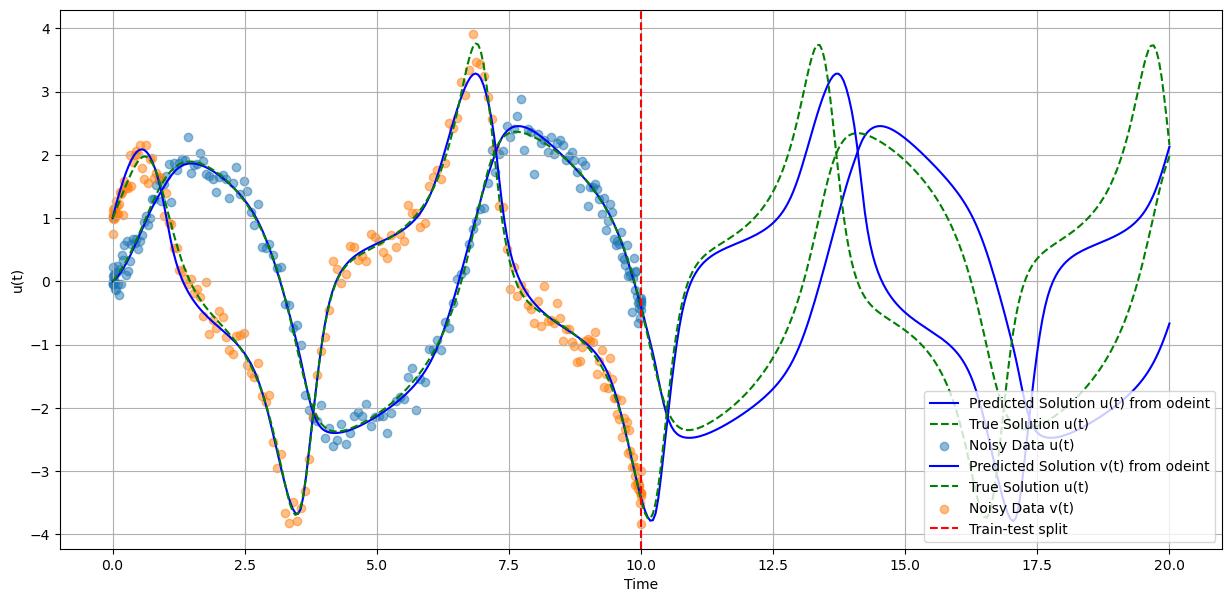

In [118]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
#plt.plot(t, u_model, 'r', alpha = 0.7, label='Predicted Solution u(t) from model.u')
plt.plot(t_test, y_pred_test.T[0], 'b', label='Predicted Solution u(t) from odeint')
plt.plot(t_test_vdp, y_test_vdp.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy_vdp.T[0], label='Noisy Data u(t)', alpha = 0.5)

#plt.plot(t, v_model, 'r', alpha = 0.7, label='Predicted Solution v(t) from model.v')
plt.plot(t_test, y_pred_test.T[1], 'b', label='Predicted Solution v(t) from odeint')
plt.plot(t_test_vdp, y_test_vdp.T[1], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy_vdp.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=10, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

#### Objective function: `mae`

In [63]:
layer_widths = [2, 20, 2]

results_tol_mae = {}
tol_li = np.logspace(-4.0, -7.0, num=10)  

for tol in tol_li:
    #---------------------------------MODEL---------------------------------#
    ode_model = ODEOptimizationModel(y_noisy, t, D, layer_widths, y_init = estimated_solution, tol = tol, objective = "mae", verbose= True, print_level= 4)
    ode_model.build_model()
    result = ode_model.solve_model()
    
    #------------------------------ ODEINT PREP ----------------------------#
    def system_dynamics(y, t):
        u, v = y
        du_dt, dv_dt = ode_model.predict(u, v)
        return jnp.array([du_dt, dv_dt])
    
    initial_conditions = jnp.array([0.0, 1.0]) 
    #---------------------------MEAN ABSOLUTE ERROR--------------------------#

    y_pred_train = odeint(system_dynamics, initial_conditions, t)    
    mae_train = jnp.mean(jnp.abs(y_pred_train - y))
    
    y_pred_test = odeint(system_dynamics, initial_conditions, t_test)   
    mae_test = jnp.mean(jnp.abs(y_pred_test[200:] - y_test[200:]))
    
    #------------------------------SAVING RESULTS----------------------------#

    results_tol_mae[tol] = {
        "tol":tol, "y_pred_train": y_pred_train, "y_pred_test" : y_pred_test, "t" : t,
        "time_elapsed": result['solver_time'], "mae_test" : mae_test, "mae":mae_train,
        "termination_condition": result['termination_condition'], "message": result['message']
        }

Ipopt 3.14.16: print_level=4
tol=0.0001


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total number of variables............................:      502
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      398
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      

In [64]:
df_results_tol_mae = pd.DataFrame(results_tol_mae).T

df_results_tol_mae['tol_scientific'] = df_results_tol_mae['tol'].apply(lambda x: f"{x:.2e}")
df_results_tol_mae = df_results_tol_mae.sort_values(by = 'tol', ascending = False)
df_results_tol_mae[['tol_scientific', 'time_elapsed', 'mae_test', 'mae', 'termination_condition']]

,tol_scientific,time_elapsed,mae_test,mae,termination_condition
1.000000e-04,1.00e-04,5.201868,11.159602397979809,8.155324402670749,optimal
4.641589e-05,4.64e-05,5.625127,11.159602397979645,8.155324402670693,optimal
2.154435e-05,2.15e-05,34.138761,0.05742624535687385,0.03778916009513595,optimal
1.000000e-05,1.00e-05,34.176476,0.05742624535687385,0.03778916009513595,optimal
4.641589e-06,4.64e-06,45.409736,0.05742624535687385,0.03778916009513595,optimal
2.154435e-06,2.15e-06,421.883153,0.04632829755884573,0.04971383537413036,maxIterations
1.000000e-06,1.00e-06,461.521834,0.04632829755884573,0.04971383537413036,maxIterations
4.641589e-07,4.64e-07,426.97621,0.04632829755884573,0.04971383537413036,maxIterations
2.154435e-07,2.15e-07,424.19686,0.04632829755884573,0.04971383537413036,maxIterations
1.000000e-07,1.00e-07,448.301817,0.04632829755884573,0.04971383537413036,maxIterations


### Potential further investigations for later
If the solver has not met the strict `tol_criteria` but has found a solution <br>
that meets the `acceptable_tol` criteria for successive `acceptable_iter` iterations, it can terminate early

https://matpower.org/docs/ref/matpower5.0/ipopt_options.html

https://coin-or.github.io/Ipopt/OPTIONS.html#OPT_s_max

In [48]:
tol_range = np.logspace(-4.5, -6.5, num=5)  
acceptable_tol_range = np.logspace(-4.0, -5.5, num=5) 
acceptable_iter_range = [500, 1000, 1500] 

----

### `dual_inf_tol`
(dual infeasibility tolerance) controls the tolerance for the dual infeasibility, which is related to the constraints' feasibility in the optimization problem

In [75]:
layer_widths = [2, 20, 2]

results_dual_inf_tol= {}
params_li = [{'dual_inf_tol':0.1},{'dual_inf_tol':1}, {'dual_inf_tol':10}, {'dual_inf_tol':100}, {'dual_inf_tol':1000}, {'dual_inf_tol':10000}]

for i, params in enumerate(params_li):
    #---------------------------------MODEL---------------------------------#
    ode_model = ODEOptimizationModel(y_noisy, t, D, layer_widths, y_init = estimated_solution, tol = 1e-5, verbose= True, print_level = 5, params = params)
    ode_model.build_model()
    result = ode_model.solve_model()
    
    #------------------------------ ODEINT PREP ----------------------------#
    def system_dynamics(y, t):
        u, v = y
        du_dt, dv_dt = ode_model.predict(u, v)
        return jnp.array([du_dt, dv_dt])
    
    initial_conditions = jnp.array([0.0, 1.0]) 
    #---------------------------MEAN ABSOLUTE ERROR--------------------------#

    y_pred_train = odeint(system_dynamics, initial_conditions, t)    
    mae_train = jnp.mean(jnp.abs(y_pred_train - y))
    
    y_pred_test = odeint(system_dynamics, initial_conditions, t_test)   
    mae_test = jnp.mean(jnp.abs(y_pred_test[200:] - y_test[200:]))
    
    #------------------------------SAVING RESULTS----------------------------#

    results_dual_inf_tol[i + 5] = {
        "dual_inf_tol": params['dual_inf_tol'], "y_pred_train": y_pred_train, "y_pred_test" : y_pred_test, "t" : t,
        "time_elapsed": result['solver_time'], "mae_test" : mae_test, "mae":mae_train,
        "termination_condition": result['termination_condition'], "message": result['message']
        }

Ipopt 3.14.16: print_level=5
tol=1e-05
dual_inf_tol=0.1


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   112236
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   125769

Total number of variables............................:      502
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraint

In [76]:
df_dual_inf_tol = pd.DataFrame(results_dual_inf_tol).T
df_dual_inf_tol[['dual_inf_tol', 'time_elapsed', 'mae_test', 'mae', 'termination_condition']]

,dual_inf_tol,time_elapsed,mae_test,mae,termination_condition
5,0.1,23.686362,0.03842784422302616,0.01853774741306302,optimal
6,1,20.828231,0.03842784422302616,0.01853774741306302,optimal
7,10,23.481273,0.03842784422302616,0.01853774741306302,optimal
8,100,22.215631,0.03842784422302616,0.01853774741306302,optimal
9,1000,24.561199,0.03842784422302616,0.01853774741306302,optimal
10,10000,27.508388,0.03842784422302616,0.01853774741306302,optimal


### `mu_strategy`

In [79]:
layer_widths = [2, 20, 2]

results_mu = {}
params_li = [{'mu_strategy':'adaptive'}, {'mu_strategy':'monotone'}]

for i, params in enumerate(params_li):
    #---------------------------------MODEL---------------------------------#
    ode_model = ODEOptimizationModel(y_noisy, t, D, layer_widths, y_init = estimated_solution, tol = 1e-5, verbose= True, print_level = 5, params = params)
    ode_model.build_model()
    result = ode_model.solve_model()
    
    #------------------------------ ODEINT PREP ----------------------------#
    def system_dynamics(y, t):
        u, v = y
        du_dt, dv_dt = ode_model.predict(u, v)
        return jnp.array([du_dt, dv_dt])
    
    initial_conditions = jnp.array([0.0, 1.0]) 
    #---------------------------MEAN ABSOLUTE ERROR--------------------------#

    y_pred_train = odeint(system_dynamics, initial_conditions, t)    
    mae_train = jnp.mean(jnp.abs(y_pred_train - y))
    
    y_pred_test = odeint(system_dynamics, initial_conditions, t_test)   
    mae_test = jnp.mean(jnp.abs(y_pred_test[200:] - y_test[200:]))
    
    #------------------------------SAVING RESULTS----------------------------#

    results_mu[i] = {
        "mu_strategy":params['mu_strategy'], "y_pred_train": y_pred_train, "y_pred_test" : y_pred_test, "t" : t,
        "time_elapsed": result['solver_time'], "mae_test" : mae_test, "mae":mae_train,
        "termination_condition": result['termination_condition'], "message": result['message']
        }

Ipopt 3.14.16: print_level=5
tol=1e-05
mu_strategy=adaptive


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   112236
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   125769

Total number of variables............................:      502
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constr

In [80]:
df_mu = pd.DataFrame(results_mu).T
df_mu[['mu_strategy', 'time_elapsed', 'mae_test', 'mae', 'termination_condition']]

,mu_strategy,time_elapsed,mae_test,mae,termination_condition
0,adaptive,23.481745,0.03842784422302616,0.01853774741306302,optimal
1,monotone,20.125953,0.03842784422302616,0.01853774741306302,optimal
